# CloakHat Patch Generation Pipeline

## 1: Conda Setup

Activate <br>
`conda env create -f environment.yaml` <br>
`conda activate cloakhat` <br>
Deactivate <br>
`conda deactivate` <br>
`conda env remove -n cloakhat` <br>


Or

Set up the environment

`conda create -n cloakhat python=3.10 -y` <br>
`conda activate cloakhat`

PyTorch with CUDA <br>
`conda install pytorch ipykernel torchvision pytorch-cuda=11.8 -c pytorch -c nvidia -y`

PyTorch3D for differentiable rendering <br>
`conda install -c pytorch3d pytorch3d -y`

Detection models <br>
`pip install ultralytics`

Pip stuff <br>
`pip install opencv-python-headless matplotlib tqdm tensorboard pyyaml trimesh`


Either way

Apply the kernel <br>
`python -m ipykernel install --user --name cloakhat --display-name "Python (cloakhat)"`

## 2: Python Setup

Get the libraries we need

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import logging

from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (look_at_view_transform, FoVPerspectiveCameras, RasterizationSettings, MeshRenderer, MeshRasterizer, SoftPhongShader, TexturesUV, PointLights)

from ultralytics import YOLO

logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(message)s')
logger = logging.getLogger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Device: {device}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/jovyan/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


2026-02-04 17:23:17,540 | Device: cuda


## 3: Config

Control variables

In [2]:
CONFIG = {
    'dataset_dir': './data/drone_footage', #Drone footage
    'mesh_path': './assets/hat.obj', #Hat meshes
    'output_dir': './outputs',
    
    #Generator
    'latent_channels': 128,
    'latent_size': 9, #Spatial size of latent input
    'texture_size': 288, #Output texture size from generator
    
    #Viewpoint sampling
    'elevation_range': (60, 90), #Degrees from horizontal (90 = overhead)
    'scale_range': (0.3, 1.2), #Altitude proxy
    
    #Training Stage 1
    'stage1_epochs': 100,
    'stage1_batch_size': 8,
    'stage1_lr': 2e-4,
    
    #Training Stage 2  
    'stage2_iterations': 2000,
    'stage2_lr': 0.01,
    'local_latent_size': 18, #Size of optimizable latent pattern
    
    #Loss weights
    'lambda_tv': 2.5, #Total variation
    'lambda_nps': 0.01, #Non-printability score
    'lambda_info': 0.1, #Mutual information (Stage 1 only)
    
    #T-SEA Stuff
    'cutout_prob': 0.9,
    'cutout_ratio': 0.4,
    'shakedrop_prob': 0.5,
    
    #Rendering
    'render_size': 256,
    
    #Printing (PLACEHOLDER, need details from FABLAB)
    'nps_threshold': 0.7,  #Saturation * brightness threshold
    
    #Attack config (white, gray, black)
    'attack_mode': 'gray',
}

Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

## 4: FCN Generator

Make the texture (turn noise into an image)

In [3]:
class FCNGenerator(nn.Module):
    
    def __init__(self, latent_channels=128):
        super().__init__()
        
        self.net = nn.Sequential(
            #9 -> 9
            nn.Conv2d(latent_channels, 512, 3, 1, 1, padding_mode='zeros'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),     
            #9 -> 18
            nn.ConvTranspose2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            #18 -> 36
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 36 -> 72
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 72 -> 144
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 144 -> 288
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # 288 -> 288 (to RGB)
            nn.Conv2d(32, 3, 3, 1, 1, padding_mode='zeros'),
            nn.Tanh()
        )
        self.output_size = 288
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, a=0.2, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, z):
        return self.net(z)
    
    def generate(self, z=None, batch_size=1):
        if z is None:
            z = torch.randn(batch_size, 128, 9, 9, device=next(self.parameters()).device)
        return (self.forward(z) + 1) / 2

# Test
generator = FCNGenerator().to(device)
test_texture = generator.generate(batch_size=1)
logger.info(f"Generator output: {test_texture.shape}")  #Should be (1, 3, 288, 288)

2026-02-04 17:23:36,326 | Generator output: torch.Size([1, 3, 288, 288])


## 5: Auxiliary Network

Forces the texture to derive from the latent

In [4]:
class AuxiliaryNetwork(nn.Module):
    def __init__(self, latent_channels=128):
        super().__init__()
        
        #Texture encoder
        self.tex_enc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )
        
        #Latent encoder
        self.lat_enc = nn.Sequential(
            nn.Conv2d(latent_channels, 256, 3, 1, 1), nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )
        
        #Joint network
        self.joint = nn.Sequential(
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
        
    def forward(self, texture, z):
        tex_feat = self.tex_enc(texture)
        lat_feat = self.lat_enc(z)
        return self.joint(torch.cat([tex_feat, lat_feat], dim=1))


def compute_mi_loss(aux_net, texture, z):

    #Matched pairs
    T_joint = aux_net(texture, z)
    pos_term = -F.softplus(-T_joint).mean()
    
    #Mismatched pairs (shuffle z)
    z_shuffle = z[torch.randperm(z.size(0))]
    T_marginal = aux_net(texture, z_shuffle)
    neg_term = F.softplus(T_marginal).mean()
    
    mi = pos_term - neg_term
    return -mi  #Negate because we minimize loss but want to maximize MI

## 6: Render Hat

Render the hat using the texture and capture angle

2026-02-04 17:23:47,419 | Mesh not found at ./assets/hat.obj. Using placeholder.
2026-02-04 17:23:48,979 | Rendered shape: torch.Size([1, 3, 256, 256]), alpha shape: torch.Size([1, 1, 256, 256])


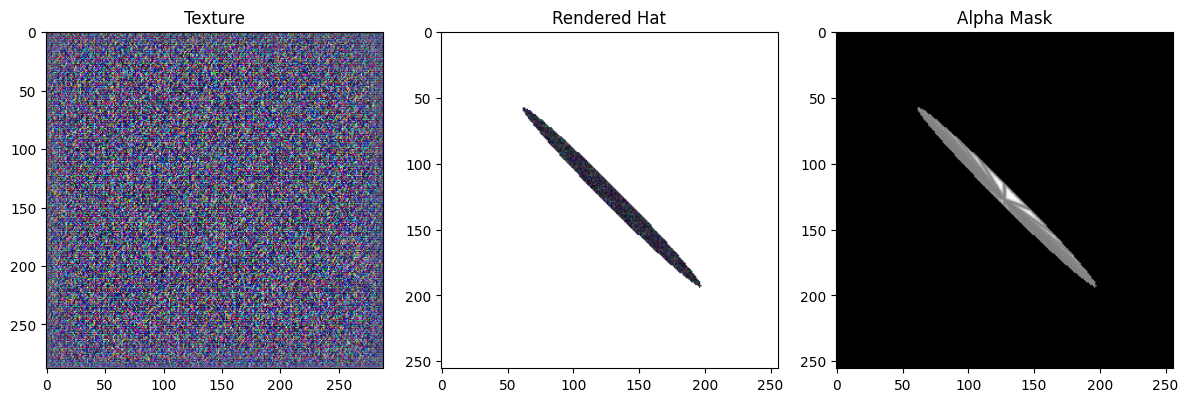

In [5]:
class HatRenderer:
    def __init__(self, mesh_path, render_size=256, device='cuda'):
        self.device = device
        self.render_size = render_size
        
        #Load mesh
        self.mesh_loaded = False
        if Path(mesh_path).exists():
            verts, faces, aux = load_obj(mesh_path, device=device)
            self.verts = verts
            self.faces = faces.verts_idx
            self.verts_uvs = aux.verts_uvs
            self.faces_uvs = faces.textures_idx
            self.mesh_loaded = True
            logger.info(f"Loaded mesh: {len(verts)} verts, {len(self.faces)} faces")
        else:
            logger.warning(f"Mesh not found at {mesh_path}. Using placeholder.")
            self._create_placeholder_mesh()
            
        #Rasterization settings
        self.raster_settings = RasterizationSettings(image_size=render_size, blur_radius=0.0, faces_per_pixel=1)
    
    #This method was made with help from ChatGPT
    def _create_placeholder_mesh(self):
        #Simple disk
        n_points = 32
        angles = torch.linspace(0, 2*np.pi, n_points+1)[:-1]
        #Vertices: center + rim
        verts = [[0, 0, 0]]  # center
        for a in angles:
            verts.append([torch.cos(a).item(), torch.sin(a).item(), 0])
        self.verts = torch.tensor(verts, dtype=torch.float32, device=self.device)
        #Faces: triangles from center to rim
        faces = []
        for i in range(n_points):
            faces.append([0, i+1, (i % n_points) + 2 if i < n_points-1 else 1])
        self.faces = torch.tensor(faces, dtype=torch.int64, device=self.device)
        #UVs: simple radial mapping
        uvs = [[0.5, 0.5]]  # center
        for a in angles:
            uvs.append([0.5 + 0.5*torch.cos(a).item(), 0.5 + 0.5*torch.sin(a).item()])
        self.verts_uvs = torch.tensor(uvs, dtype=torch.float32, device=self.device)
        self.faces_uvs = self.faces.clone()
        self.mesh_loaded = True
        
    def sample_viewpoint(self):
        #Elevation: beta distribution skewed toward overhead
        elev_norm = np.random.beta(3, 1)
        elev = CONFIG['elevation_range'][0] + elev_norm * (CONFIG['elevation_range'][1] - CONFIG['elevation_range'][0])
        #Azimuth: uniform
        azim = np.random.uniform(0, 360)
        #Scale: uniform
        scale = np.random.uniform(*CONFIG['scale_range'])
        return elev, azim, scale
    
    def render(self, texture, elevation=90, azimuth=0, scale=1.0):
        batch_size = texture.shape[0]
        #Scale vertices
        verts = self.verts * scale
        #Camera setup
        dist = 2.5  #Camera distance
        R, T = look_at_view_transform(dist=dist, elev=elevation, azim=azimuth, device=self.device)
        cameras = FoVPerspectiveCameras(R=R, T=T, device=self.device)
        #Lighting (varying lighting)
        light_x = np.random.uniform(-1, 1)
        light_y = np.random.uniform(1, 3)  #Always somewhat above
        light_z = np.random.uniform(-1, 1)
        lights = PointLights(device=self.device, location=[[light_x, light_y, light_z]],ambient_color=[[0.5, 0.5, 0.5]],diffuse_color=[[0.3, 0.3, 0.3]],specular_color=[[0.2, 0.2, 0.2]])
        
        rendered_images = []
        alpha_masks = []
        
        for i in range(batch_size):
            #Create texture for this sample
            tex = TexturesUV(maps=texture[i:i+1].permute(0, 2, 3, 1), faces_uvs=[self.faces_uvs], verts_uvs=[self.verts_uvs])
            #Create mesh
            mesh = Meshes(verts=[verts], faces=[self.faces], textures=tex)
            #Renderer
            renderer = MeshRenderer(rasterizer=MeshRasterizer(cameras=cameras, raster_settings=self.raster_settings), shader=SoftPhongShader(device=self.device, cameras=cameras, lights=lights))
            #Render
            images = renderer(mesh)
            rendered_images.append(images[..., :3].permute(0, 3, 1, 2))
            alpha_masks.append(images[..., 3:4].permute(0, 3, 1, 2))
            
        return torch.cat(rendered_images, dim=0), torch.cat(alpha_masks, dim=0)

#Test renderer
renderer = HatRenderer(CONFIG['mesh_path'], CONFIG['render_size'], device)
test_render, test_alpha = renderer.render(test_texture, elevation=85, azimuth=45)
logger.info(f"Rendered shape: {test_render.shape}, alpha shape: {test_alpha.shape}")

#Visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(test_texture[0].permute(1,2,0).detach().cpu())
axes[0].set_title('Texture')
axes[1].imshow(test_render[0].permute(1,2,0).detach().cpu())
axes[1].set_title('Rendered Hat')
axes[2].imshow(test_alpha[0, 0].detach().cpu(), cmap='gray')
axes[2].set_title('Alpha Mask')
plt.tight_layout()
plt.show()

## 7: T-SEA Augmentations

Helper methods for black/gray/white box transfers

In [6]:
#Randomly mask a region of the rendered hat. Prevents overfitting to specific texture patterns.
def patch_cutout(rendered_hat, alpha_mask, prob=0.9, ratio=0.4, fill=0.5):
    if np.random.random() > prob:
        return rendered_hat
    B, C, H, W = rendered_hat.shape
    #Random cutout size
    cut_h = int(H * ratio)
    cut_w = int(W * ratio)
    #Random position
    top = np.random.randint(0, H - cut_h + 1)
    left = np.random.randint(0, W - cut_w + 1)
    #Apply cutout (only where alpha > 0)
    mask = alpha_mask.clone()
    mask[:, :, top:top+cut_h, left:left+cut_w] = 0
    rendered_hat = rendered_hat * mask + fill * (1 - mask) * (alpha_mask > 0).float()
    return rendered_hat

#Mild augmentations that don't distort the image too much.
def constrained_augmentation(image):
    B, C, H, W = image.shape
    #Random scale (0.9 - 1.1)
    scale = np.random.uniform(0.9, 1.1)
    new_size = int(H * scale)
    image = F.interpolate(image, size=new_size, mode='bilinear', align_corners=False)
    #Crop/pad back to original size
    if new_size > H:
        start = (new_size - H) // 2
        image = image[:, :, start:start+H, start:start+W]
    else:
        pad = (H - new_size) // 2
        image = F.pad(image, [pad, pad, pad, pad], mode='reflect')
        image = image[:, :, :H, :W]
    #Color jitter (mild)
    brightness = np.random.uniform(0.9, 1.1)
    image = image * brightness
    #Random horizontal flip
    if np.random.random() > 0.5:
        image = torch.flip(image, dims=[3])
    return image.clamp(0, 1)

#ShakeDrop reates virtual ensemble of model variants
def shakedrop_forward(model, x, drop_prob=0.5, alpha_range=(0, 2)):
    #I will make a simplified version: add noise to intermediate features
    if np.random.random() < drop_prob:
        alpha = np.random.uniform(*alpha_range)
        noise = torch.randn_like(x) * 0.1 * alpha
        x = x + noise
    return x

## 8: URAdv Augmentations

For better performance under drone conditions

In [7]:
#Add simulated light reflections on the hat surface.
def add_light_spots(image, alpha_mask, num_range=(0, 3), intensity_range=(0.1, 0.4)):
    if np.random.random() > 0.5:
        return image
    B, C, H, W = image.shape
    num_spots = np.random.randint(*num_range)
    for _ in range(num_spots):
        #Random spot position (within hat region)
        cy = np.random.randint(H // 4, 3 * H // 4)
        cx = np.random.randint(W // 4, 3 * W // 4)
        #Spot parameters
        radius = np.random.uniform(0.05, 0.15) * min(H, W)
        intensity = np.random.uniform(*intensity_range)
        #Create Gaussian spot
        y, x = torch.meshgrid(torch.arange(H, device=image.device), torch.arange(W, device=image.device), indexing='ij')
        dist = ((x - cx) ** 2 + (y - cy) ** 2).float()
        spot = torch.exp(-dist / (2 * radius ** 2)) * intensity
        #Apply only within hat (where alpha > 0)
        spot = spot.unsqueeze(0).unsqueeze(0) * (alpha_mask > 0).float()
        image = image + spot
    return image.clamp(0, 1)

#Add simulated shadows on the hat surface.
def add_shadows(image, alpha_mask, num_range=(0, 2), opacity_range=(0.2, 0.5)):
    if np.random.random() > 0.5:
        return image
    B, C, H, W = image.shape
    num_shadows = np.random.randint(*num_range)
    for _ in range(num_shadows):
        #Random shadow as diagonal stripe
        angle = np.random.uniform(0, np.pi)
        opacity = np.random.uniform(*opacity_range)
        width = np.random.uniform(0.1, 0.3) * min(H, W)
        #Create shadow mask
        y, x = torch.meshgrid(torch.arange(H, device=image.device), torch.arange(W, device=image.device), indexing='ij')
        offset = np.random.uniform(0, H)
        dist = torch.abs(x * np.cos(angle) + y * np.sin(angle) - offset)
        shadow = (dist < width).float() * opacity
        #Apply only within hat
        shadow = shadow.unsqueeze(0).unsqueeze(0) * (alpha_mask > 0).float()
        image = image * (1 - shadow)
    return image.clamp(0, 1)

#Simulate printer color/brightness variation.
def simulate_printing(texture, mul_std=0.1, add_std=0.05):
    #Multiplicative noise
    mul_noise = torch.randn_like(texture) * mul_std + 1.0
    texture = texture * mul_noise
    #Additive noise
    add_noise = torch.randn_like(texture) * add_std
    texture = texture + add_noise
    return texture.clamp(0, 1)

#Apply camera artifacts: blur, noise.
def apply_environmental_augmentation(image, prob=0.3):
    #Motion blur
    if np.random.random() < prob:
        kernel_size = np.random.choice([3, 5, 7])
        kernel = torch.zeros(kernel_size, kernel_size, device=image.device)
        kernel[kernel_size//2, :] = 1.0 / kernel_size
        #Random rotation of kernel
        angle = np.random.uniform(0, 360)
        # Simplified: just apply horizontal blur
        image = F.conv2d(image, kernel.view(1, 1, kernel_size, kernel_size).expand(3, 1, -1, -1), padding=kernel_size//2, groups=3)
    #Gaussian noise
    if np.random.random() < prob:
        noise_std = np.random.uniform(0.01, 0.05)
        image = image + torch.randn_like(image) * noise_std
    return image.clamp(0, 1)

## 9: Toroidal Cropping

Wrapping the texture

In [8]:
class ToroidalLatent:
    
    def __init__(self, local_size, crop_size=9, latent_channels=128, device='cuda'):
        self.local_size = local_size
        self.crop_size = crop_size
        self.latent_channels = latent_channels
        self.device = device
        #Initialize local latent pattern
        self.z_local = nn.Parameter(torch.randn(1, latent_channels, local_size, local_size, device=device) * 0.1)
        
    def get_random_crops(self, batch_size):
        #Tile 3x3 for wraparound
        z_tiled = self.z_local.repeat(1, 1, 3, 3)
        
        crops = []
        for _ in range(batch_size):
            #Random offset within middle tile (to enable wraparound)
            i = np.random.randint(self.local_size, 2 * self.local_size)
            j = np.random.randint(self.local_size, 2 * self.local_size)
            crop = z_tiled[:, :, i:i+self.crop_size, j:j+self.crop_size]
            crops.append(crop)
            
        return torch.cat(crops, dim=0)
    
    def get_full_latent(self, target_spatial_size):
        reps = (target_spatial_size + self.local_size - 1) // self.local_size + 1
        z_tiled = self.z_local.repeat(1, 1, reps, reps)
        return z_tiled[:, :, :target_spatial_size, :target_spatial_size]